In [1]:
import numpy as np
import pandas as pd
import gget
import glob
import networkx as nx
import os
import seaborn as sns
import gget
from textwrap import fill
import scanpy as sc
import anndata as an
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix 

# locals
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3  

# Load data 

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.X = adata.layers['raw_counts'].copy()
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

sc.pp.normalize_total(
        adata, 
        target_sum=1e6,
        key_added='norm_factor',
)

adata.layers["cpm"] = adata.X.copy()

adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2', 'norm_factor'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts', 'cpm'
    obsp: 'connectivi

# Plot functions

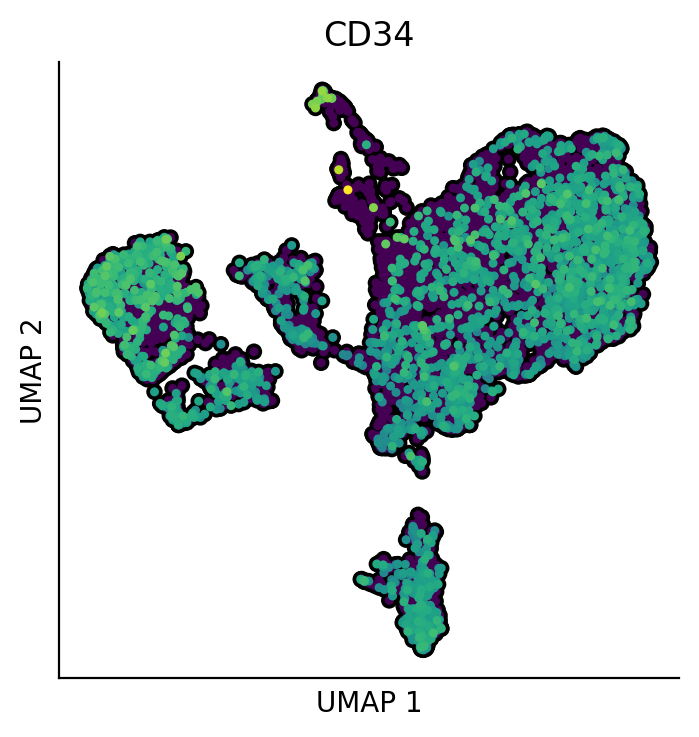

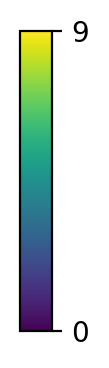

In [4]:
def plot_gene_expression(adata, query):
    """
    Plots gene expression on a UMAP embedding and displays expression range.

    Args:
        adata: An AnnData object containing UMAP coordinates and gene expression data.
        query: The name of the gene to plot expression for.
    """

    # Extract expression data and sort by expression value
    expression = np.ravel(adata[:, query].X)
    sort_order = np.argsort(expression)

    # Plot background UMAP in light grey
    sns.scatterplot(
        data=adata.obs,
        x='UMAP 1',
        y='UMAP 2',
        ec='none', 
        s=35,
        color='k',
    )

    # Plot gene expression on UMAP, colored by expression level
    scatter = plt.scatter(
        adata.obs['UMAP 1'].values[sort_order],
        adata.obs['UMAP 2'].values[sort_order],
        c=np.log1p(expression[sort_order]),
        s=5
    )
    
    # Display expression range and add plot title
    plt.title(query)
    plt.xticks([])
    plt.yticks([])
    sns.despine()
    plt.show()
    
    
    plt2.make_colorbar(tick_labels=[
        f"{min(np.log1p(expression)):.0f}",
        f"{max(np.log1p(expression)):.0f}",
    ])
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
query = 'CD34'
plot_gene_expression(adata, query)

In [11]:
pang = adata.uns['panglaodb']

end_genes = list(pang[pang['cell_type'] == 'Endothelial cells']['gene_name'].unique())
print(len(end_genes))

end_genes = [x for x in end_genes if x in adata.var_names]
print(len(end_genes))

end_genes[:10]

145
145


['PECAM1',
 'ITGB3',
 'SELE',
 'VCAM1',
 'MCAM',
 'TEK',
 'FLT4',
 'THBD',
 'PLVAP',
 'ACKR1']

/tmp/ipykernel_361680/1644942837.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('cluster').mean().T


gene_name cluster        value
0     EDNRB      C1  2260.260742
1     HSPG2      C1   691.676941
2   ADORA2A      C1   320.544434
3    PECAM1      C1   144.889938
4     CASZ1      C1   150.390015

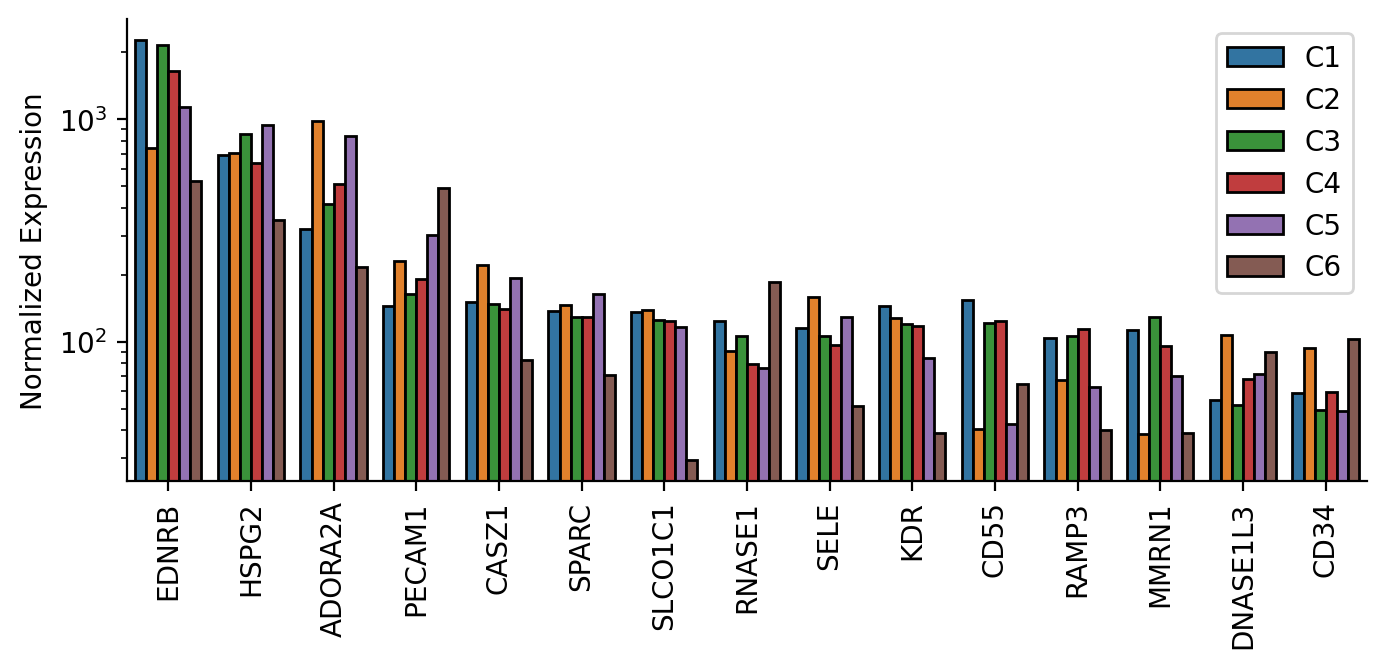

In [65]:
n_genes = 15

df = adata[:, end_genes].to_df()
df['cluster'] = adata.obs['cluster_str']
df = df.groupby('cluster').mean().T

columns = list(df.columns)

df['sum'] = df[columns].sum(axis=1)
df['mean'] = df[columns].mean(axis=1)
df['median'] = df[columns].median(axis=1)
df['std'] = df[columns].std(axis=1)

df = df.sort_values(by='mean', ascending=False).reset_index(names='gene_name')
df = df.head(n_genes)

df = pd.melt(df, id_vars='gene_name', value_vars=columns)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 3

sns.barplot(
    df, 
    x='gene_name',
    y='value',
    hue='cluster',
    ec='k',
)
plt.yscale('log')
plt.ylabel('Normalized Expression')
plt.xlabel('')
sns.despine()
plt.gca().tick_params(axis='x', rotation=90)
sns.move_legend(
    plt.gca(),
    loc='best',
    title="",
)

df.head()

# DEG

In [70]:
pdf = adata[:, end_genes].copy()

sc.tl.rank_genes_groups(
    pdf, 
    groupby="cluster_str",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='deg',
)

deg = sc.get.rank_genes_groups_df(
    pdf, 
    group=None,
    key='deg',
)

deg.head()

ranking genes
    finished: added to `.uns['deg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:452: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:453: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:452: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:452: RuntimeWarning: overflow encountered in expm1
  foldchanges = (sel

group   names     scores  logfoldchanges          pvals      pvals_adj  \
0    C1   EDNRB  30.945988             NaN  2.876914e-210  4.171526e-208   
1    C1    CD55  21.516308      102.669022  1.095481e-102  5.294824e-101   
2    C1   MMRN1  11.258728       44.341366   2.097648e-29   7.603976e-28   
3    C1    ESM1   9.715387       38.720013   2.592603e-22   6.265458e-21   
4    C1  RNASE1   9.693486       39.798111   3.213689e-22   6.656926e-21   

   pct_nz_group  pct_nz_reference  
0      0.987522          0.872304  
1      0.601732          0.390854  
2      0.507003          0.401639  
3      0.336134          0.232097  
4      0.526865          0.440466

In [74]:
pvals_adj = 0.05
logfoldchanges = 1.0
n_gene = 3
sig = deg.copy()
sig = sig[sig['logfoldchanges'] >= logfoldchanges]

sig = sig.sort_values(
    by=['group', 'logfoldchanges'], 
    ascending=[True, False],
)

sig = sig.groupby('group').head(n_gene)

sig

group    names     scores  logfoldchanges          pvals      pvals_adj  \
1      C1     CD55  21.516308      102.669022  1.095481e-102  5.294824e-101   
2      C1    MMRN1  11.258728       44.341366   2.097648e-29   7.603976e-28   
4      C1   RNASE1   9.693486       39.798111   3.213689e-22   6.656926e-21   
145    C2  ADORA2A  33.348938             inf  7.547126e-244  5.471667e-242   
148    C2    CASZ1  10.591272      100.884293   3.271148e-26   5.928956e-25   
147    C2      MGP  11.020720       85.804985   3.036234e-28   7.337566e-27   
291    C3    HSPG2  10.708629             inf   9.272500e-27   6.722563e-25   
292    C3    MMRN1   8.174392       58.746883   2.973623e-16   1.437251e-14   
293    C3    RAMP3   4.116979       21.236202   3.838708e-05   5.060116e-04   
435    C4    ADIRF  14.497269       80.200943   1.260673e-47   1.827976e-45   
436    C4     TIE1  10.699217       56.418655   1.026415e-26   7.441511e-25   
437    C4    IFI27   9.933722       44.393867   2.969607e-23   1.435310e-21   
580    C5  ADORA2A  14.461154             inf   2.131946e-47   3.091322e-45   
581    C5   PECAM1  13.619821      180.884842   3.053150e-42   2.213534e-40   
583    C5      MGP   8.675043       57.918037   4.133934e-18   9.990339e-17   
828    C6   PECAM1  -2.712679      450.602142   6.674171e-03   2.274901e-02   
793    C6   ADGRL4  -1.031375      162.748154   3.023652e-01   5.693890e-01   
771    C6     CAV1  -0.369818      115.687515   7.115182e-01   9.945032e-01   

     pct_nz_group  pct_nz_reference  
1        0.601732          0.390854  
2        0.507003          0.401639  
4        0.526865          0.440466  
145      0.901826          0.800176  
148      0.648402          0.612979  
147      0.321918          0.177947  
291      0.932084          0.947484  
292      0.553279          0.424216  
293      0.518150          0.435449  
435      0.403654          0.048738  
436      0.518272          0.243814  
437      0.475083          0.212662  
580      0.953020          0.813701  
581      0.874720          0.616806  
583      0.447427          0.194184  
828      0.314961          0.635017  
793      0.149606          0.237553  
771      0.055118          0.078473

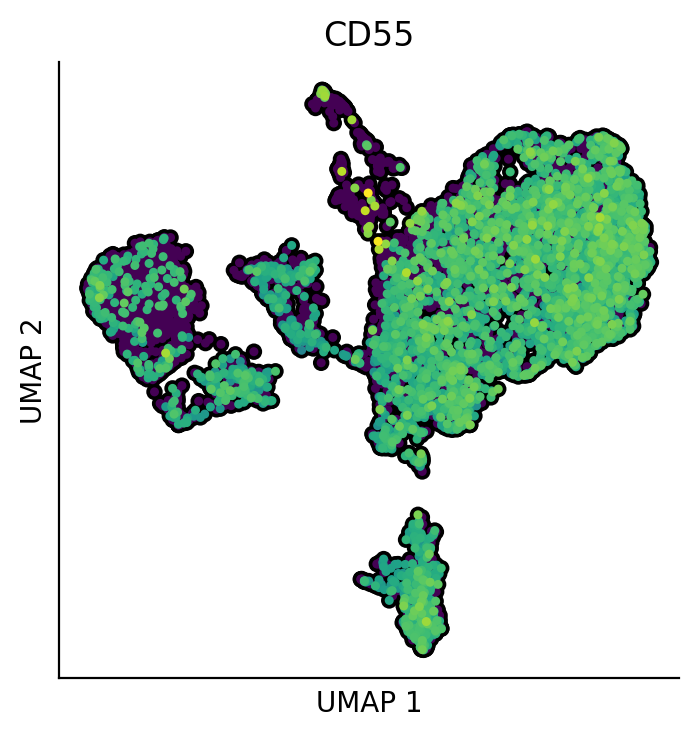

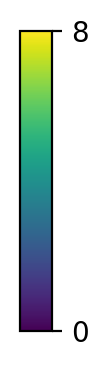

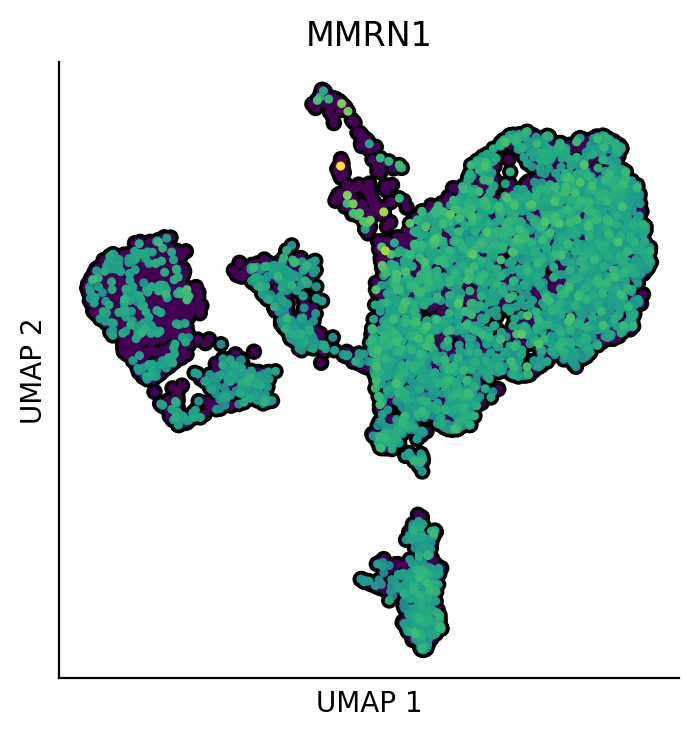

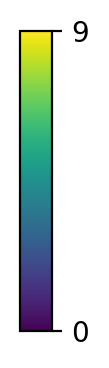

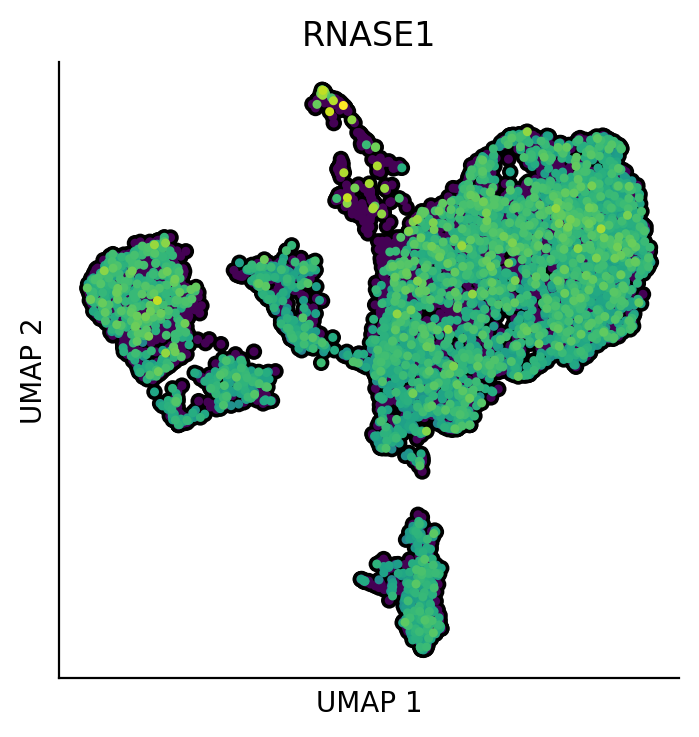

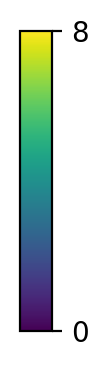

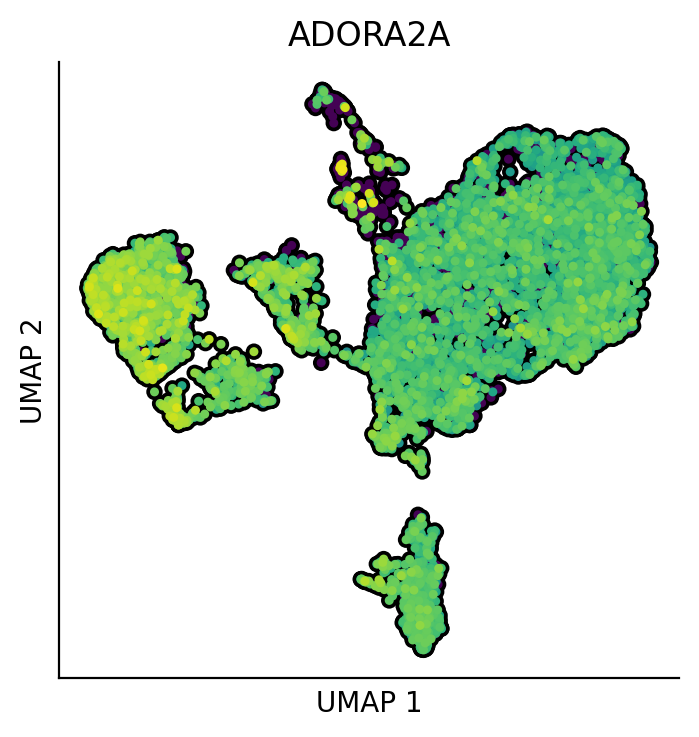

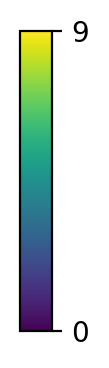

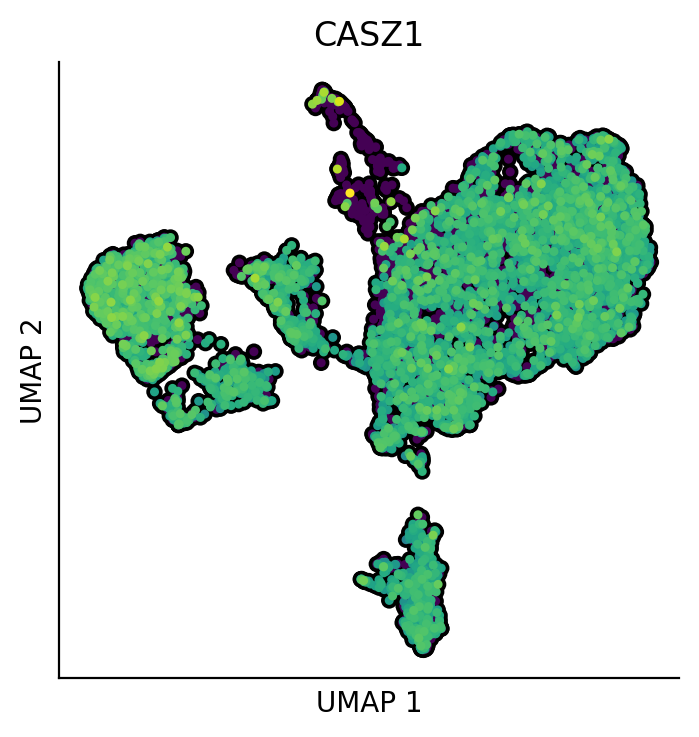

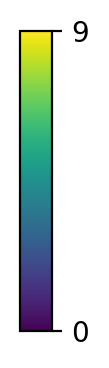

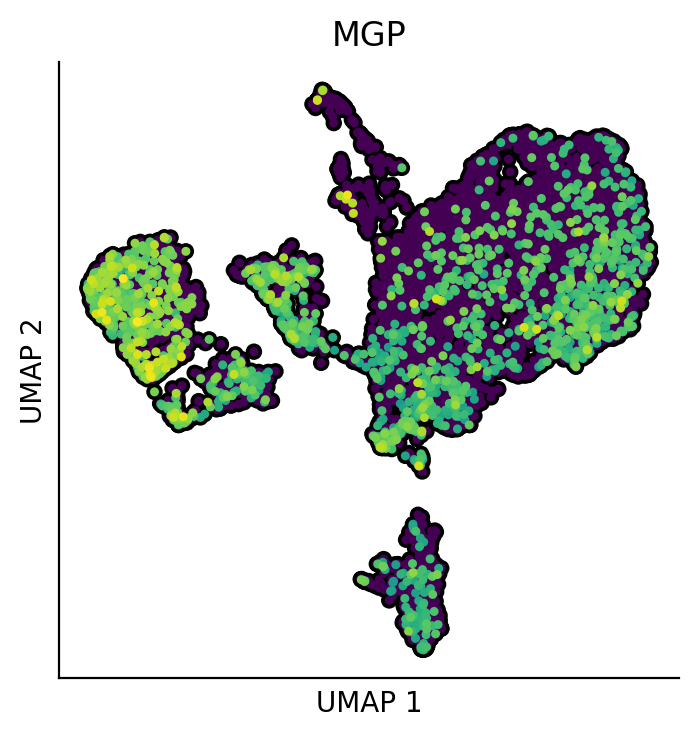

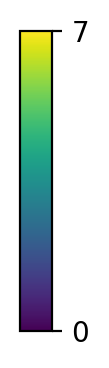

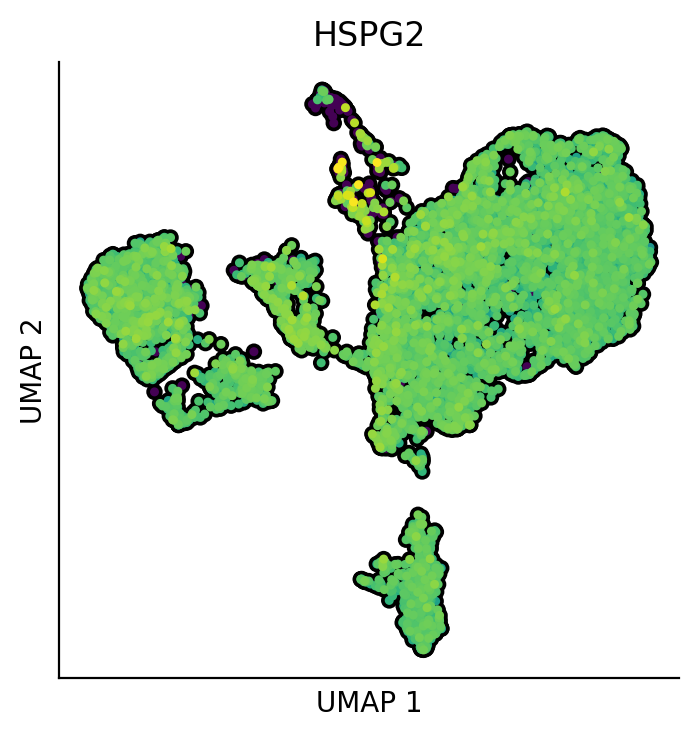

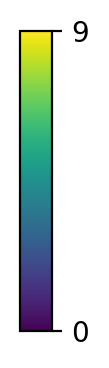

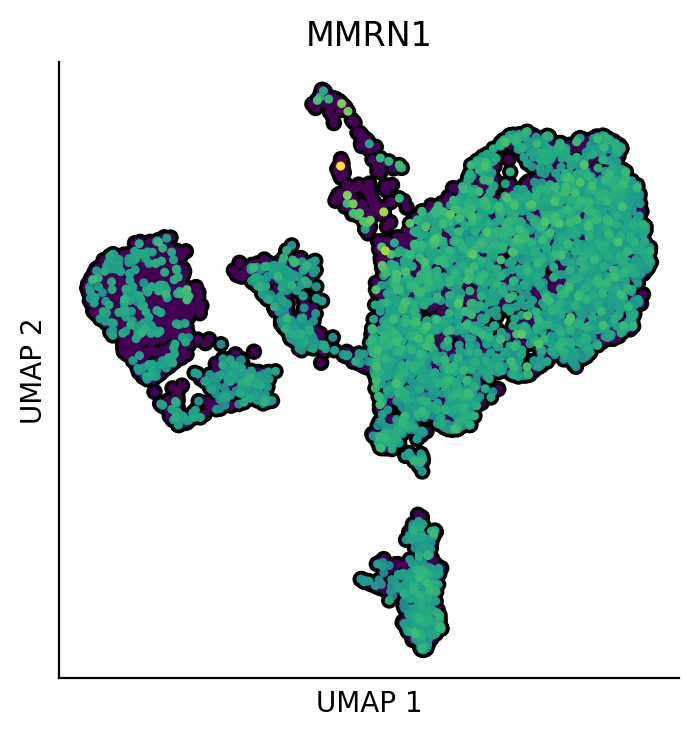

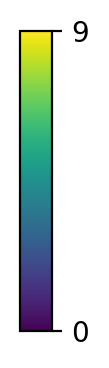

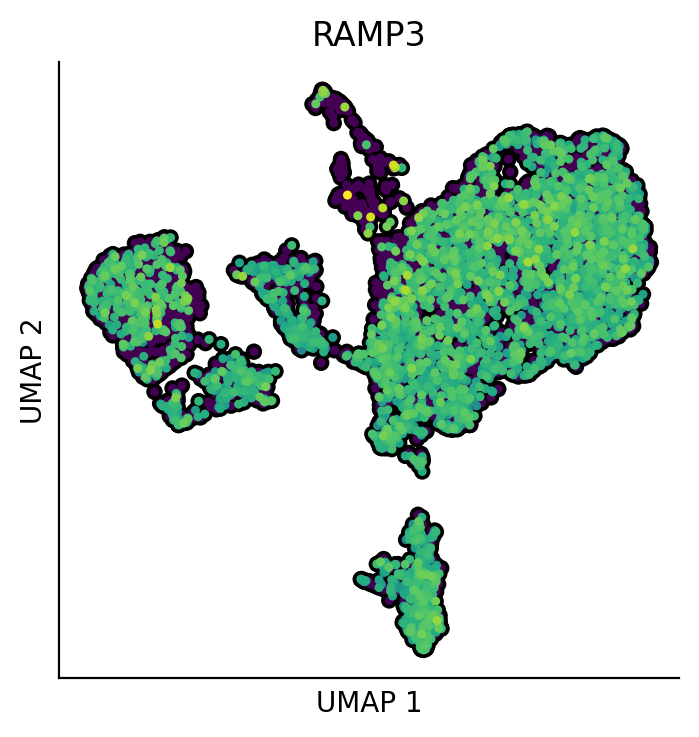

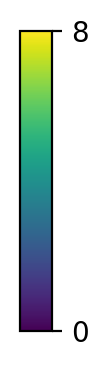

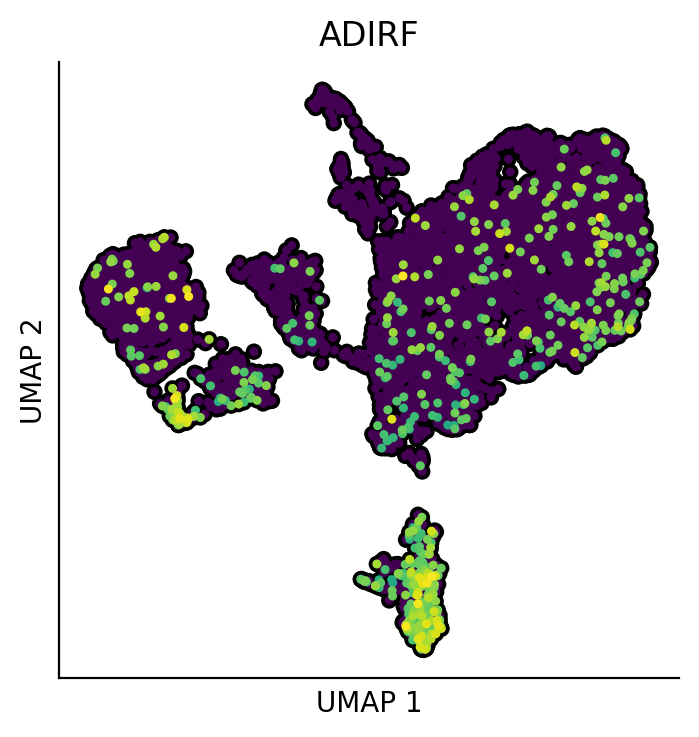

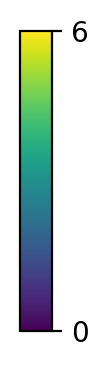

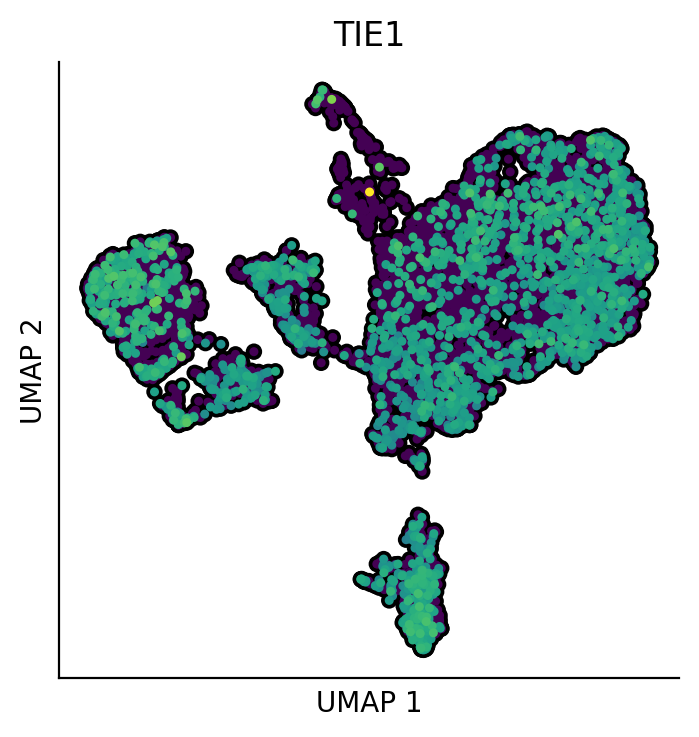

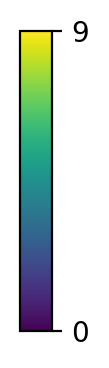

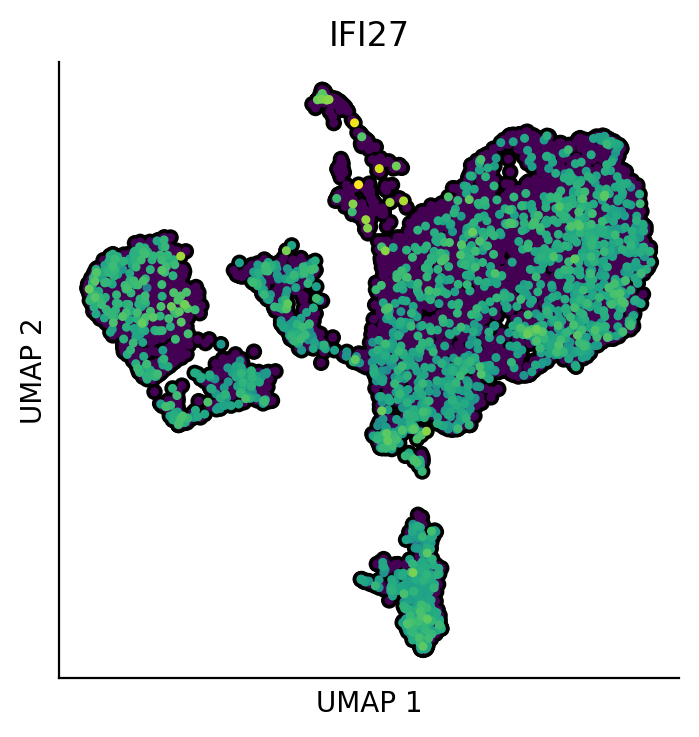

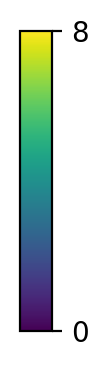

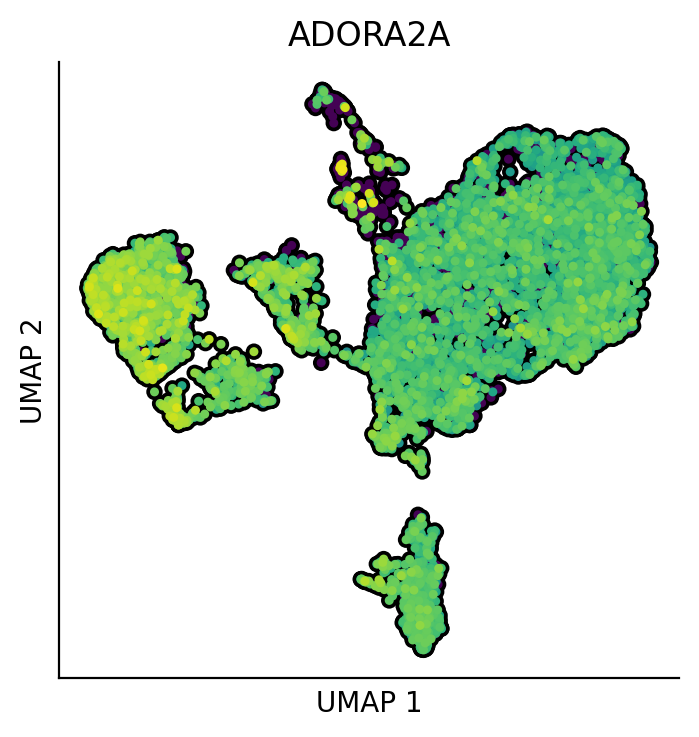

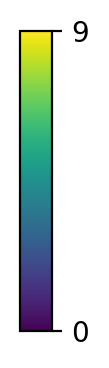

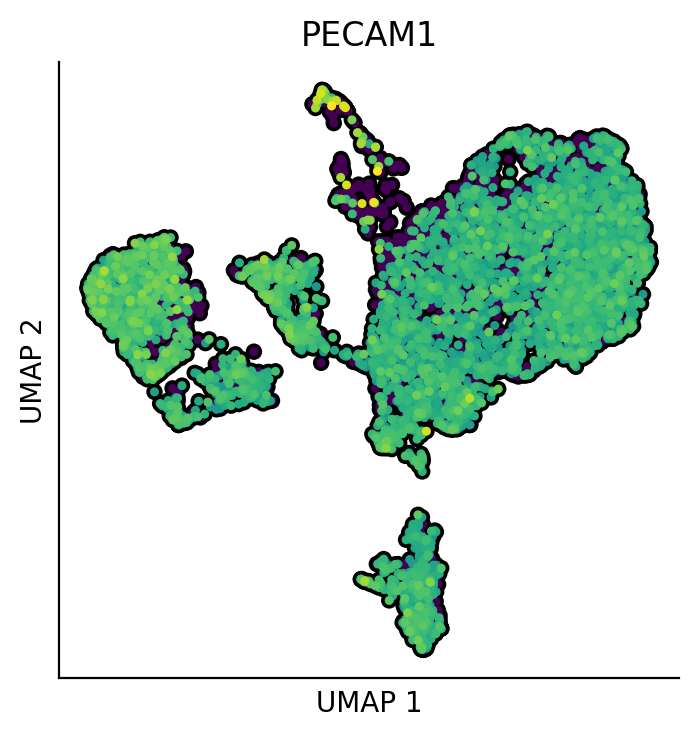

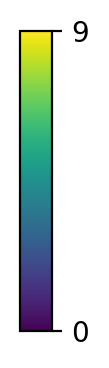

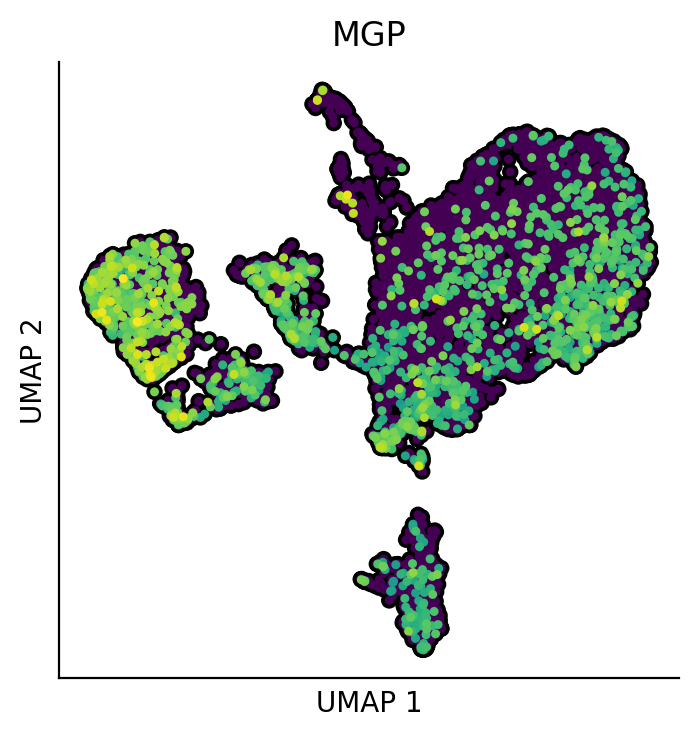

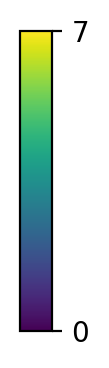

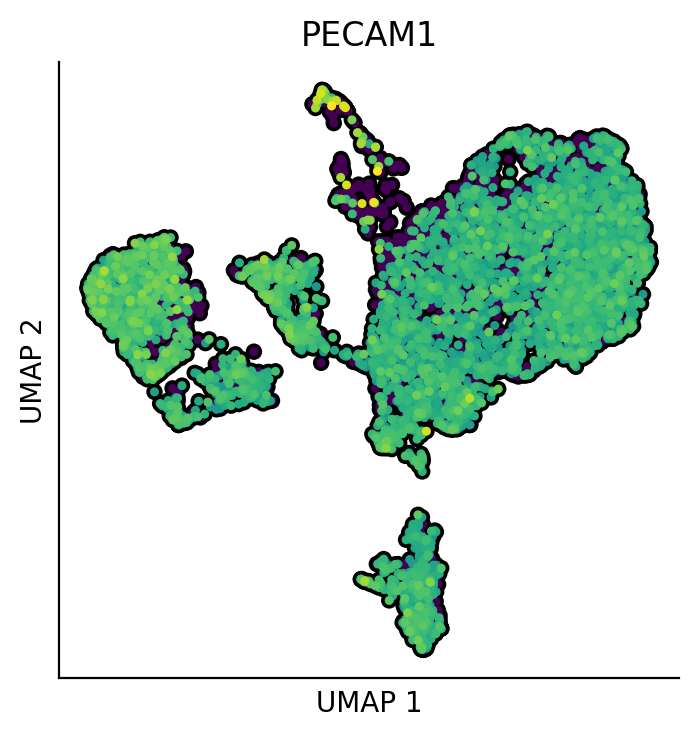

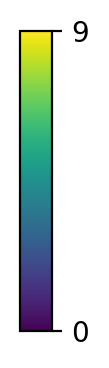

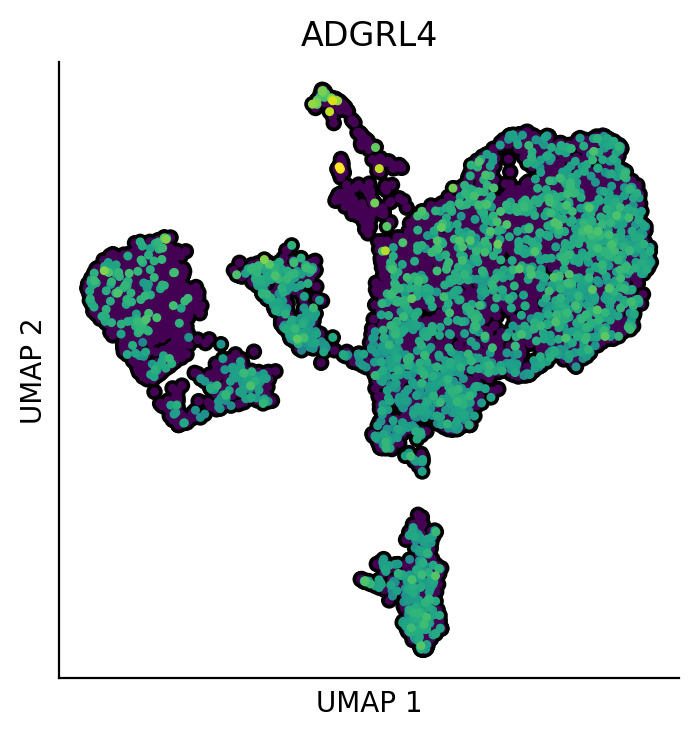

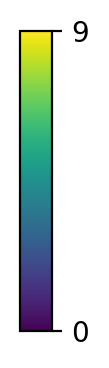

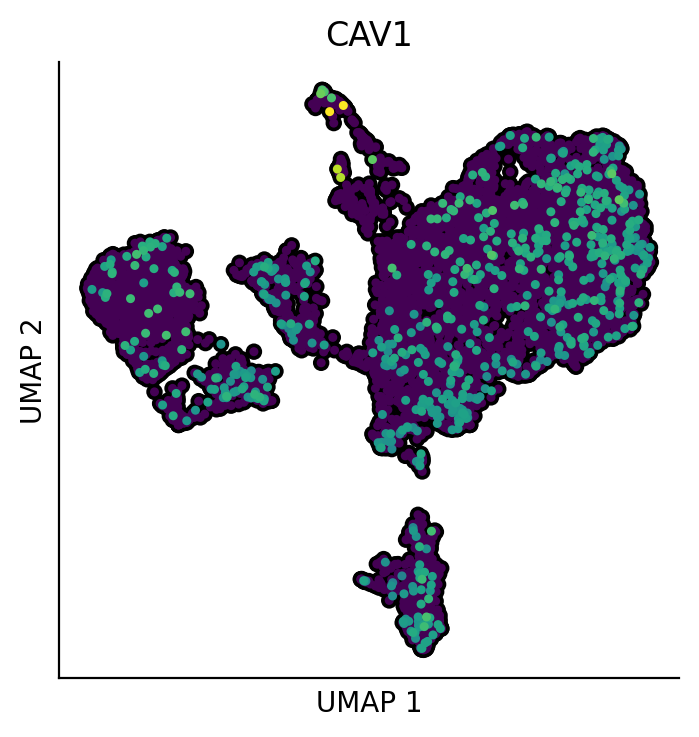

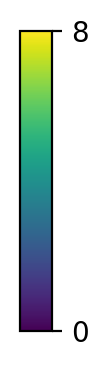

In [75]:
for gene in sig['names'].to_list():
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4, 4
    plot_gene_expression(adata, gene)
    plt.show()